## Imports

In [0]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt


def denorm(x, channels=None, w=None ,h=None, resize = False):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        else:
            x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))


### Device Selection

In [0]:
GPU = True
device_idx = 0
use_cuda = True

if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


### Reproducibility

In [0]:
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

### Data loading

In [0]:
batch_size = 128

if not os.path.exists('./CW/CAE'):
    os.makedirs('./CW/CAE')
if not os.path.exists('./CW/DCGAN'):
    os.makedirs('./CW/DCGAN')


NUM_TRAIN = 49000

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


data_dir = './datasets'
cifar10_train = datasets.CIFAR10(data_dir, train=True, download=True,
                             transform=transform)
cifar10_val = datasets.CIFAR10(data_dir, train=True, download=True,
                           transform=transform)
cifar10_test = datasets.CIFAR10(data_dir, train=False, download=True, 
                            transform=transform)

loader_train = DataLoader(cifar10_train, batch_size=batch_size, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
loader_val = DataLoader(cifar10_val, batch_size=batch_size, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]
save_image(denorm(fixed_input), './CW/CAE/input_sample.png')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Convolutional Autoencoder

### Part 1.1 (30 points)

### Hyper-parameter selection

In [0]:
num_epochs = 20
learning_rate  = 0.001


### Define model

In [0]:
import torch.nn as nn
hidden_size = 256


class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        

        enc_channel_1 = 60
        enc_kernel_size_1 = 3
        enc_stride_1 = 1       
        enc_padding_1 = 1
        
        enc_channel_2 = 80
        enc_kernel_size_2 = 3
        enc_stride_2 = 1       
        enc_padding_2 = 1
        
        enc_channel_3 = 120
        enc_kernel_size_3 = 3
        enc_stride_3 = 1       
        enc_padding_3 = 0
        
        enc_channel_4 = 160
        enc_kernel_size_4 = 2
        enc_stride_4 = 1       
        enc_padding_4 = 0
        
        self.final_channels = enc_channel_4
        
        self.final_size = 2
    
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(
                in_channels = 3,
                out_channels = enc_channel_1,
                kernel_size = enc_kernel_size_1,
                stride = enc_stride_1,
                padding = enc_padding_1
            ),
            
            nn.ReLU(),
            
            nn.BatchNorm2d(enc_channel_1),
            
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2
            ),
            
            nn.Conv2d(
                in_channels = enc_channel_1,
                out_channels = enc_channel_2,
                kernel_size = enc_kernel_size_2,
                stride = enc_stride_2,
                padding = enc_padding_2
            ),
            
            nn.ReLU(),
            
            nn.BatchNorm2d(enc_channel_2),
            
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2
            ),
            
            nn.Conv2d(
                in_channels = enc_channel_2,
                out_channels = enc_channel_3,
                kernel_size = enc_kernel_size_3,
                stride = enc_stride_3,
                padding = enc_padding_3
            ),
            
            nn.ReLU(),
            
            nn.BatchNorm2d(enc_channel_3),
            
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2
            ),
            
            nn.Conv2d(
                in_channels = enc_channel_3,
                out_channels = enc_channel_4,
                kernel_size = enc_kernel_size_4,
                stride = enc_stride_4,
                padding = enc_padding_4
            )

        )
        
        self.encoder_linear = nn.Linear(enc_channel_4*self.final_size**2,hidden_size)
        
        self.decoder_linear = nn.Linear(hidden_size,enc_channel_4*self.final_size**2)
        
        
        dec_channel_1 = 120
        dec_kernel_size_1 = 4
        dec_stride_1 = 2      
        dec_padding_1 = 0
        
        dec_channel_2 = 80
        dec_kernel_size_2 = 4
        dec_stride_2 = 2      
        dec_padding_2 = 0
        
        dec_channel_3 = 60
        dec_kernel_size_3 = 4
        dec_stride_3 = 2      
        dec_padding_3 = 0
        
        dec_channel_4 = 3
        dec_kernel_size_4 = 3
        dec_stride_4 = 1       
        dec_padding_4 = 0 
        
        
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels = enc_channel_4,
                out_channels = dec_channel_1,
                kernel_size = dec_kernel_size_1,
                stride = dec_stride_1,
                padding = dec_padding_1
            ),

            nn.ReLU(),
            
            nn.BatchNorm2d(dec_channel_1),
            
            nn.ConvTranspose2d(
                in_channels = dec_channel_1,
                out_channels = dec_channel_2,
                kernel_size = dec_kernel_size_2,
                stride = dec_stride_2,
                padding = dec_padding_2
            ),
            
            nn.ReLU(),
            
            nn.BatchNorm2d(dec_channel_2),
            
            nn.ConvTranspose2d(
                in_channels = dec_channel_2,
                out_channels = dec_channel_3,
                kernel_size = dec_kernel_size_3,
                stride = dec_stride_3,
                padding = dec_padding_3
            ),
            
            nn.ReLU(),
            
            nn.ConvTranspose2d(
                in_channels = dec_channel_3,
                out_channels = dec_channel_4,
                kernel_size = dec_kernel_size_4,
                stride = dec_stride_4,
                padding = dec_padding_4
            ),
            
            nn.Tanh()
        ) 
     

    def encode(self, x):

 
        x = self.encoder_conv(x)
        x = x.view(x.shape[0],-1)
        x = self.encoder_linear(x)
        
        return x
  
    
    def decode(self, z):

 
        z = self.decoder_linear(z)
        z = z.view(z.shape[0],self.final_channels,self.final_size,self.final_size)
        z = self.decoder_conv(z)
        
        return (z)

    def forward(self, x):
        z = self.encode(x)
        recon = self.decode(z)
        return recon

### Define Loss function

In [0]:
criterion = nn.MSELoss(reduction='mean') 
def loss_function_CAE(recon_x, x):
    recon_loss = criterion(recon_x, x)
    return recon_loss

### Initialize Model and print number of parameters

In [0]:
model = CAE().to(device)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)

Total number of parameters is: 1077419
CAE(
  (encoder_conv): Sequential(
    (0): Conv2d(3, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(60, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(80, 120, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(120, 160, kernel_size=(2, 2), stride=(1, 1))
  )
  (encoder_linear): Linear(in_features=640, out_features=256, bias=True)
  (decod

### Optimizer choice

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train

In [0]:
train_losses = []
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, data in enumerate(loader_train):
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        # Forward
        recon_batch = model(img)
        loss = loss_function_CAE(recon_batch, img)
        # Backward
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    # Print out losses and save reconstructions for every epoch
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss / len(loader_train)))
    recon = model(fixed_input.to(device))
    recon = denorm(recon.cpu())
    save_image(recon, './CW/CAE/reconstructed_epoch_{}.png'.format(epoch))
    train_losses.append(train_loss/ len(loader_train))

# Save the model and the loss values
np.save('./CW/CAE/train_losses.npy', np.array(train_losses))
torch.save(model.state_dict(), './CW/CAE/CAE_model.pth')

epoch [1/20], loss:0.0693
epoch [2/20], loss:0.0422
epoch [3/20], loss:0.0350
epoch [4/20], loss:0.0306
epoch [5/20], loss:0.0273
epoch [6/20], loss:0.0251
epoch [7/20], loss:0.0233
epoch [8/20], loss:0.0221
epoch [9/20], loss:0.0212
epoch [10/20], loss:0.0203
epoch [11/20], loss:0.0194
epoch [12/20], loss:0.0189
epoch [13/20], loss:0.0182
epoch [14/20], loss:0.0178
epoch [15/20], loss:0.0173
epoch [16/20], loss:0.0170
epoch [17/20], loss:0.0166
epoch [18/20], loss:0.0162
epoch [19/20], loss:0.0161
epoch [20/20], loss:0.0156


### Train loss curve

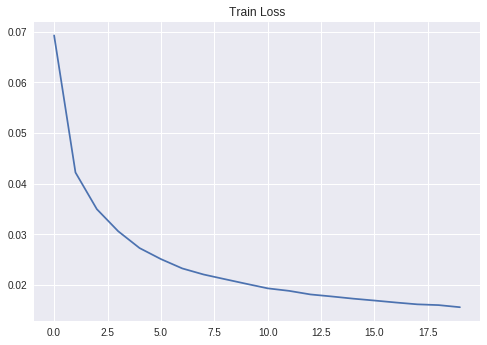

In [0]:
import matplotlib.pyplot as plt
train_losses = np.load('./CW/CAE/train_losses.npy')
plt.plot(list(range(0,train_losses.shape[0])), train_losses)
plt.title('Train Loss')
plt.show()

### Test set reconstruction error

In [0]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
model.eval()
test_loss = 0
with torch.no_grad():
    for i, data in enumerate(loader_test):
        img,_ = data
        img = img.to(device)
        recon_batch = model(img)
        test_loss += loss_function_CAE(recon_batch, img)
    # loss calculated over the whole test set
    test_loss /= len(loader_test.dataset)
    print('Test set loss: {:.4f}'.format(test_loss))

Test set loss: 0.0001


### Test set images and reconstructions

Sample images from the dataset:

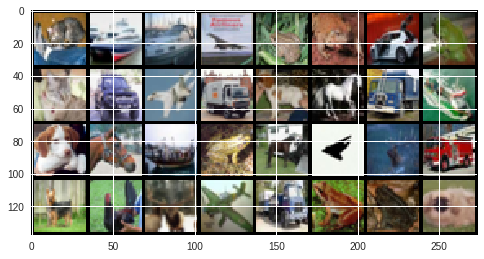

In [0]:
# load the model
model.load_state_dict(torch.load('./CW/CAE/CAE_model.pth'))
it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:32, :, :, :]

img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                range=None, scale_each=False, pad_value=0)
show(img)

Visualisation of reconstructed images:

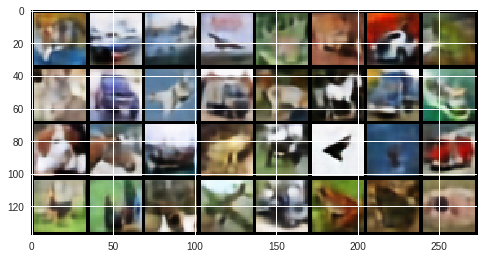

In [0]:
with torch.no_grad():
    recon_batch = model(fixed_input.to(device)).cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            range=None, scale_each=False, pad_value=0)
    show(recon_batch)

## Classification using encoding

We specify a number of classifiers to use:

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
classifier = svm.SVC(kernel='linear', C=0.01)
y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    return ax

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

model_rf = RandomForestClassifier(
    n_estimators = 50,
    min_samples_leaf = 5
)

model_nn = MLPClassifier(
    hidden_layer_sizes = [150,100],
    activation = "relu"
)

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np



def test_model(model,classifier,loader_test):
  test_iter = iter(loader_test)

  counter=1
  all_classes = []
  all_pred = []
  print("Testing model:")
  try:
    while True:
      img, classes = next(test_iter)
      img = img.to(device)

      encoded_img = model.encode(img)
      classes_pred = classifier.predict(encoded_img.tolist())
      all_classes.extend(classes)
      all_pred.extend(classes_pred)

      counter+=1
      if counter%20==0:
        print("x",end="")
  except StopIteration:
    acc = accuracy_score(all_classes,all_pred)
    print()
    print("Accuracy achieved: {}".format(acc))
    return acc
    #plot_confusion_matrix(all_classes,all_pred,np.arange(10),normalize=True)
    
def train_and_eval_model(model,classifier,loader_train,loader_test,num_epochs,verbose=True):

  train_losses = []

  train_iter = iter(loader_train)

  for epoch in range(num_epochs):
    print('\nepoch [{}/{}]'
            .format(epoch + 1, num_epochs))
    counter = 1
    train_loss = 0
    counter = 1
    train_iter = iter(loader_train)
    try:
      while True:
        img, classes = next(train_iter)
        #img, _ = data
        img = img.to(device)

        encoded_img = model.encode(img)
        classifier.partial_fit(encoded_img.tolist(),classes,np.arange(10))
        counter+=1
        if counter%20==0:
          print("x",end="")
    except StopIteration:
      if verbose or epoch == num_epochs-1:
        print()
        acc = test_model(model,classifier,loader_test)
      print()
  return acc



In [0]:
import numpy as np

num_layers_options = [
    [100],
    [100,100],
    [150,100,50],
    [50],
    [200],
    [200,100,50]
]

num_epochs = 6
res={}
for i, setup in enumerate(num_layers_options):
  print("Evaluating model using following architecture: ",setup)
  classifier = MLPClassifier(setup)
  acc = train_and_eval_model(model,classifier,loader_train,loader_test,num_epochs,False)
  res["model "+str(i)]={
      "architecture": setup,
      "accuracy": acc 
  }

Evaluating model using following architecture:  [100]

epoch [1/6]
xxxxxxxxxxxxxxxxxxx

epoch [2/6]
xxxxxxxxxxxxxxxxxxx

epoch [3/6]
xxxxxxxxxxxxxxxxxxx

epoch [4/6]
xxxxxxxxxxxxxxxxxxx

epoch [5/6]
xxxxxxxxxxxxxxxxxxx

epoch [6/6]
xxxxxxxxxxxxxxxxxxx
Testing model:
xxxx
Accuracy achieved: 0.5548

Evaluating model using following architecture:  [100, 100]

epoch [1/6]
xxxxxxxxxxxxxxxxxxx

epoch [2/6]
xxxxxxxxxxxxxxxxxxx

epoch [3/6]
xxxxxxxxxxxxxxxxxxx

epoch [4/6]
xxxxxxxxxxxxxxxxxxx

epoch [5/6]
xxxxxxxxxxxxxxxxxxx

epoch [6/6]
xxxxxxxxxxxxxxxxxxx
Testing model:
xxxx
Accuracy achieved: 0.5618

Evaluating model using following architecture:  [150, 100, 50]

epoch [1/6]
xxxxxxxxxxxxxxxxxxx

epoch [2/6]
xxxxxxxxxxxxxxxxxxx

epoch [3/6]
xxxxxxxxxxxxxxxxxxx

epoch [4/6]
xxxxxxxxxxxxxxxxxxx

epoch [5/6]
xxxxxxxxxxxxxxxxxxx

epoch [6/6]
xxxxxxxxxxxxxxxxxxx
Testing model:
xxxx
Accuracy achieved: 0.5676

Evaluating model using following architecture:  [50]

epoch [1/6]
xxxxxxxxxxxxxxxxxxx

ep

In [0]:
import pandas as pd

res_df = pd.DataFrame(res)
res_df.T.sort_values(by='accuracy', ascending=False)

,accuracy,architecture
model 5,0.5712,"[200, 100, 50]"
model 4,0.5693,[200]
model 2,0.5676,"[150, 100, 50]"
model 1,0.5618,"[100, 100]"
model 0,0.5548,[100]
model 3,0.5422,[50]


We see a clear relationship between the size of the architecture and the accuracy achieved on the validation data. We will therefore fit another selection of larger classifiers to determine whether there is further performance which can be unlocked.

In [0]:
import numpy as np

num_layers_options = [
    [200,200],
    [300,200,100],
    [300,300],
    [400,200,100]
]

num_epochs = 6
res={}
for i, setup in enumerate(num_layers_options):
  print("Evaluating model using following architecture: ",setup)
  classifier = MLPClassifier(setup)
  acc = train_and_eval_model(model,classifier,loader_train,loader_test,num_epochs,False)
  res["model "+str(i)]={
      "architecture": setup,
      "accuracy": acc 
  }

Evaluating model using following architecture:  [200, 200]

epoch [1/6]
xxxxxxxxxxxxxxxxxxx

epoch [2/6]
xxxxxxxxxxxxxxxxxxx

epoch [3/6]
xxxxxxxxxxxxxxxxxxx

epoch [4/6]
xxxxxxxxxxxxxxxxxxx

epoch [5/6]
xxxxxxxxxxxxxxxxxxx

epoch [6/6]
xxxxxxxxxxxxxxxxxxx
Testing model:
xxxx
Accuracy achieved: 0.5802

Evaluating model using following architecture:  [300, 200, 100]

epoch [1/6]
xxxxxxxxxxxxxxxxxxx

epoch [2/6]
xxxxxxxxxxxxxxxxxxx

epoch [3/6]
xxxxxxxxxxxxxxxxxxx

epoch [4/6]
xxxxxxxxxxxxxxxxxxx

epoch [5/6]
xxxxxxxxxxxxxxxxxxx

epoch [6/6]
xxxxxxxxxxxxxxxxxxx
Testing model:
xxxx
Accuracy achieved: 0.5879

Evaluating model using following architecture:  [300, 300]

epoch [1/6]
xxxxxxxxxxxxxxxxxxx

epoch [2/6]
xxxxxxxxxxxxxxxxxxx

epoch [3/6]
xxxxxxxxxxxxxxxxxxx

epoch [4/6]
xxxxxxxxxxxxxxxxxxx

epoch [5/6]
xxxxxxxxxxxxxxxxxxx

epoch [6/6]
xxxxxxxxxxxxxxxxxxx
Testing model:
xxxx
Accuracy achieved: 0.5902

Evaluating model using following architecture:  [400, 200, 100]

epoch [1/6]
xxxxxx

In [0]:
import pandas as pd

res_df = pd.DataFrame(res)
res_df.T.sort_values(by='accuracy', ascending=False)

,accuracy,architecture
model 2,0.5902,"[300, 300]"
model 1,0.5879,"[300, 200, 100]"
model 3,0.5879,"[400, 200, 100]"
model 0,0.5802,"[200, 200]"


It seems that there is unlikely to be much higher performance which can be achieved over the [300,300] model, especially given the very marginal improvements seen compared to similar models. We settle on this one for now as the optimum model found.